# 1. Análisis Exploratorio

In [1]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder

In [2]:
#Leyendo los datos y convirtiendolos a un data frame
df = pd.read_csv("ds_challenge_apr2021.csv")

#Desanidando columna "dispositivos" - Se agregaran nuevas columnas al final
df["dispositivo"] =  df["dispositivo"].map(lambda d : ast.literal_eval(d))
df= df.join(pd.DataFrame(df["dispositivo"].to_dict()).T)
df["Count"] = 1 # Para contar
#Añadiendo día de la semana (Solo para ver si influye)
df['fecha'] = pd.to_datetime(df['fecha'])
df['dia_semana'] = df['fecha'].dt.day_name()
df.head(5)

ID_USER genero       monto      fecha  hora  \
0        0      F  608.345634 2020-01-21    20   
1        0      F   88.719243 2020-01-15     7   
2        1      F  790.037653 2020-01-17    11   
3        1      F  767.005387 2020-01-05    11   
4        1      F  254.171053 2020-01-30    10   

                                         dispositivo establecimiento  \
0  {'model': 2020, 'device_score': 3, 'os': 'ANDR...           Super   
1  {'model': 2020, 'device_score': 1, 'os': 'ANDR...             NaN   
2      {'model': 2020, 'device_score': 1, 'os': '.'}             NaN   
3    {'model': 2020, 'device_score': 3, 'os': 'WEB'}           MPago   
4     {'model': 2020, 'device_score': 3, 'os': '%%'}             NaN   

        ciudad  tipo_tc  linea_tc  ...  status_txn is_prime       dcto  \
0       Merida   Física     71000  ...    Aceptada    False  60.834563   
1       Merida  Virtual     71000  ...    Aceptada    False   0.000000   
2  Guadalajara  Virtual     94000  ...  En proceso    False   0.000000   
3  Guadalajara   Física     94000  ...    Aceptada    False   0.000000   
4  Guadalajara   Física     94000  ...    Aceptada    False   0.000000   

    cashback  fraude  model device_score       os Count  dia_semana  
0   5.475111   False   2020            3  ANDROID     1     Tuesday  
1   1.774385   False   2020            1  ANDROID     1   Wednesday  
2  15.800753   False   2020            1        .     1      Friday  
3   7.670054   False   2020            3      WEB     1      Sunday  
4   2.541711   False   2020            3       %%     1    Thursday  

[5 rows x 21 columns]

In [3]:
#Tipo de datos en el dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26975 entries, 0 to 26974
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID_USER          26975 non-null  int64         
 1   genero           26975 non-null  object        
 2   monto            26975 non-null  float64       
 3   fecha            26975 non-null  datetime64[ns]
 4   hora             26975 non-null  int64         
 5   dispositivo      26975 non-null  object        
 6   establecimiento  16856 non-null  object        
 7   ciudad           15297 non-null  object        
 8   tipo_tc          26975 non-null  object        
 9   linea_tc         26975 non-null  int64         
 10  interes_tc       26975 non-null  int64         
 11  status_txn       26975 non-null  object        
 12  is_prime         26975 non-null  bool          
 13  dcto             26975 non-null  float64       
 14  cashback         26975 non-null  float


Primero se revisará los valores de cada columna y las transacciones por variable.

## Exploración de datos

In [4]:
#Información básica a grandes rasgos
df.describe()

ID_USER         monto          hora      linea_tc    interes_tc  \
count  26975.000000  26975.000000  26975.000000  26975.000000  26975.000000   
mean    2003.765412    499.069493     11.987618  62476.811863     48.224875   
std     1144.630736    289.309518      6.642565  21886.892902      9.587256   
min        0.000000      0.017303      1.000000  25000.000000     32.000000   
25%     1041.000000    246.521227      6.000000  44000.000000     40.000000   
50%     2006.000000    500.501022     12.000000  62000.000000     48.000000   
75%     2973.500000    749.598192     18.000000  82000.000000     57.000000   
max     3999.000000    999.917764     23.000000  99000.000000     64.000000   

               dcto      cashback    Count  
count  26975.000000  26975.000000  26975.0  
mean      17.466134      6.261186      1.0  
std       34.334566      4.458440      0.0  
min        0.000000      0.000138      1.0  
25%        0.000000      2.791740      1.0  
50%        0.000000      5.636711      1.0  
75%       18.770710      8.531604      1.0  
max      199.356251     19.991582      1.0

In [5]:
#Agrupando usuarios para poder obtener información de cada individuo 
df_user = df.groupby(["ID_USER","genero","ciudad"], dropna=False).agg({"monto":"sum", "Count":sum, "cashback":"sum"}).reset_index().sort_values(by="ID_USER")
df_user["Monto promedio por transacción"] = round(df_user["monto"]/df_user["Count"],2)
df_user.head(3)

ID_USER genero       ciudad        monto  Count   cashback  \
0        0      F       Merida   697.064876      2   7.249496   
1        1      F  Guadalajara  3416.796066      7  49.028204   
2        2      F       Toluca  2789.893416      7  28.644970   

   Monto promedio por transacción  
0                          348.53  
1                          488.11  
2                          398.56

In [6]:
#Resumen de la información hasta el momento
print("\033[1mPeriodo de evaluación:\033[0m",df["fecha"].min(), "al", df["fecha"].max(),
      "\n\033[1mCantidad de días:\033[0m",df["fecha"].nunique(),
      "\n\033[1mCantidad de usuarios únicos:\033[0m",df["ID_USER"].nunique(),
      "\n\033[1mTransacciones:\033[0m",df["Count"].sum(),
      "\n\033[1mTransacciones fraudulentas y verídicas:\033[0m \n", df["fraude"].value_counts(dropna=False),
      "\n\033[1mMonto promedio por transacción:\033[0m $",round(df["monto"].sum()/df["Count"].sum(),2),
      "\n\033[1mGénero de usuarios:\033[0m \n *Mujeres:",df_user[df_user["genero"]== "F"]["genero"].count(),
      "\n *Hombres:",df_user[df_user["genero"]!= "F"]["genero"].count(),
      "\n *Otros:",df_user[(df_user["genero"]!= "F") & (df_user["genero"]== "F")]["genero"].count(),
      "\n\033[1mTransacciones por establecimiento:\033[0m \n", df["establecimiento"].value_counts(dropna=False),
     "\n\033[1mTransacciones por dispositivos utilizados:\033[0m\n",df["os"].value_counts(dropna=False),
     "\n\033[1mTransacciones por ubicación:\033[0m\n",df_user["ciudad"].value_counts(dropna=False))


Periodo de evaluación: 2020-01-02 00:00:00 al 2020-01-30 00:00:00 
Cantidad de días: 29 
Cantidad de usuarios únicos: 4000 
Transacciones: 26975 
Transacciones fraudulentas y verídicas: 
 False    26165
True       810
Name: fraude, dtype: int64 
Monto promedio por transacción: $ 499.07 
Género de usuarios: 
 *Mujeres: 1589 
 *Hombres: 2411 
 *Otros: 0 
Transacciones por establecimiento: 
 NaN            10119
Restaurante     3454
Abarrotes       3415
Super           3402
MPago           3343
Farmacia        3242
Name: establecimiento, dtype: int64 
Transacciones por dispositivos utilizados:
 %%         6808
WEB        6766
.          6715
ANDROID    6686
Name: os, dtype: int64 
Transacciones por ubicación:
 NaN            1721
Toluca          595
Guadalajara     566
Monterrey       565
Merida          553
Name: ciudad, dtype: int64


## Visualizaciones
Puesto que la variable de interés (target) es "Fraude" es importante comparar como se comportan los valores de esta columna con respecto a los de otras columnas (features).

In [7]:
#Reemplazando nan
df = df.replace(np.nan, "desconocido")
#Función para agrupar datos por la variable en cuestión y fraude. Graficador
def fraude_vs_variable(variable):
    df_v = df.groupby([variable,"fraude"]).agg({"monto":sum, "Count":sum}).reset_index().sort_values(by=variable)
    df_v["Monto promedio por transacción"]=round(df_v["monto"]/df_v["Count"],2)
    
 #Grafica que muestra la cantidad de operaciones fraudulentas y verídicas vs variable
    fig_1 = px.bar(df_v, x=variable, y='Count', color='fraude', labels= {"Count":"No de transacciones"}, height=400,
               barmode="stack",  color_discrete_sequence = ["#51a8f6", "#c61f0c"], title="Cantidad de transacciones vs "+variable)
    fig_1.update_xaxes(nticks=24)
    fig_1.show()
    
    #Grafica que muestra exclusivamente la cantidad de operaciones fraudulentas vs variable. El color representa el monto promedio por operación.
    fig_2 = px.bar(df_v[df_v["fraude"] == True], x=variable, y='Count',color='Monto promedio por transacción', 
                   labels= {"Count":"No de transacciones"},barmode="group", height=400,
                 color_continuous_scale=px.colors.sequential.Reds, title="Cantidad de transacciones fraudulentas vs "+variable+ " - Monto promedio por transacción")
    fig_2.update_xaxes(nticks=24)
    fig_2.show()

### Género

In [8]:
fraude_vs_variable("genero")

### Fecha vs Fraude

In [9]:
fraude_vs_variable("fecha")

# Dia de la semana

In [10]:
fraude_vs_variable("dia_semana")

### Hora

In [11]:
fraude_vs_variable("hora")

### Establecimiento 

In [12]:
fraude_vs_variable("establecimiento")

### Ciudad 

In [13]:
fraude_vs_variable("ciudad")

### Tipo_ tc

In [14]:
fraude_vs_variable("tipo_tc")

### Status_txn

In [15]:
fraude_vs_variable("status_txn")

### Is_prime 

In [16]:
fraude_vs_variable("is_prime")

### Sistema operativo

In [17]:
fraude_vs_variable("os")

In [18]:
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=("Monto","linea_tc", "Interés", "Descuento", "Cashback"))
#Monto
fig.add_trace(go.Histogram(x=df[df["fraude"] == False]["monto"], name="False",marker_color="blue"),
              row=1, col=1)
fig.add_trace(go.Histogram(x=df[df["fraude"] == True]["monto"], name="True",marker_color="red"),
              row=1, col=1)
#linea_tc
fig.add_trace(go.Histogram(x=df[df["fraude"] == False]["linea_tc"],marker_color="blue"),
              row=1, col=2)
fig.add_trace(go.Histogram(x=df[df["fraude"] == True]["linea_tc"],marker_color="red"),
              row=1, col=2)
#Interés
fig.add_trace(go.Histogram(x=df[df["fraude"] == False]["interes_tc"],marker_color="blue"),
              row=1, col=3)
fig.add_trace(go.Histogram(x=df[df["fraude"] == True]["interes_tc"],marker_color="red"),
              row=1, col=3)
#Descuento
fig.add_trace(go.Histogram(x=df[df["fraude"] == False]["dcto"],marker_color="blue"),
              row=2, col=1)
fig.add_trace(go.Histogram(x=df[df["fraude"] == True]["dcto"],marker_color="red"),
              row=2, col=1)
#Cashback
fig.add_trace(go.Histogram(x=df[df["fraude"] == False]["cashback"],marker_color="blue"),
              row=2, col=2)
fig.add_trace(go.Histogram(x=df[df["fraude"] == True]["cashback"],marker_color="red"),
              row=2, col=2)

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)

fig.show()

## Revisando correlación

In [19]:
#Cambiando los valores de fraude a 0 = False y 1 = True ya que se utilizará un modelo de regresión lógistica
df_model = df.copy()
df_model["fraude"] = np.where(df_model["fraude"] == True, 1, 0)

#Encoding
def encoding(column):
    df_model[column] = LabelEncoder().fit_transform(df_model[column])
    
encoding("genero")
encoding("fecha")
encoding("establecimiento")
encoding("ciudad")
encoding("status_txn")
encoding("is_prime")
encoding("tipo_tc")
encoding("model")
encoding("os")


df_model.tail(1)

ID_USER  genero       monto  fecha  hora  \
26974     3999       2  517.209272      1    20   

                                             dispositivo  establecimiento  \
26974  {'model': 2020, 'device_score': 5, 'os': 'ANDR...                2   

       ciudad  tipo_tc  linea_tc  ...  status_txn  is_prime  dcto  cashback  \
26974       3        0     40000  ...           1         0   0.0  5.172093   

       fraude  model  device_score  os  Count  dia_semana  
26974       0      0             5   2      1      Friday  

[1 rows x 21 columns]

<AxesSubplot:>

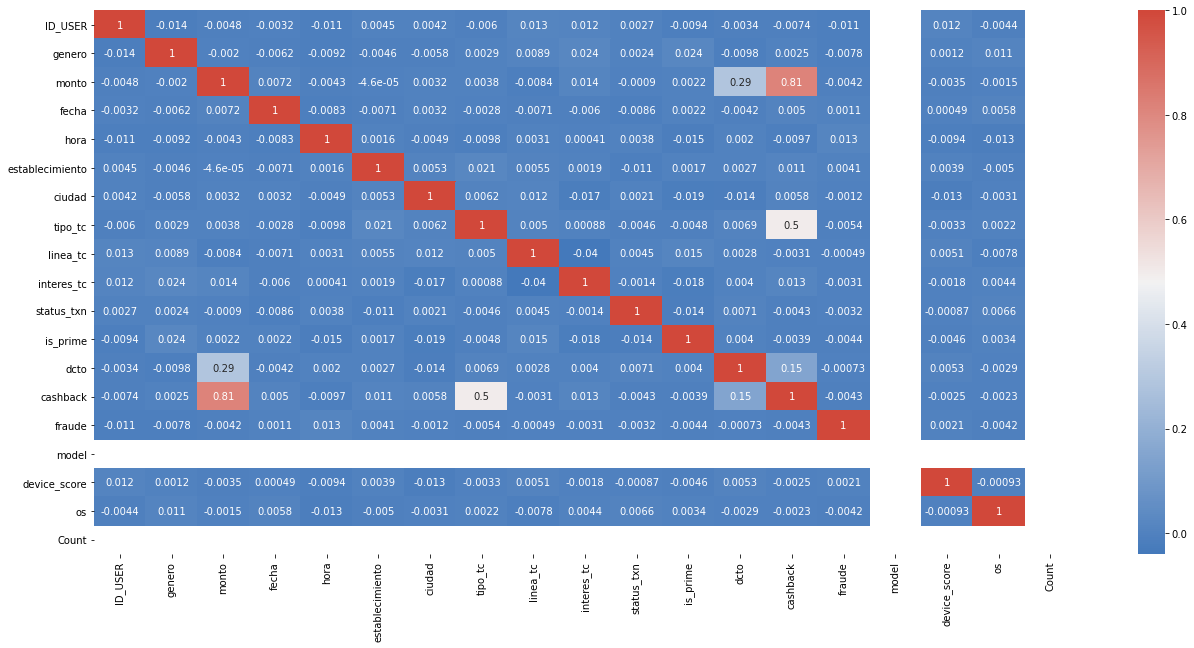

In [20]:
#Correlación entre las variables
corr = df_model.corr()

# Gráficando
f, ax = plt.subplots(figsize=(22, 10)) # Tamaño
cmap = sns.diverging_palette(250, 15, as_cmap=True) #Color
sns.heatmap(corr, annot=True,  cmap=cmap)

# Resumen de exploración de datos

De antemano se observa que es un problema imbalanceado, ya que de las 26,975 transacciones el 97% son operaciones verídicas mientras que el 3% son fraudulentas. 

Valores con más operaciones fraudulentas\
Género: Más hombres\
Día de la semana: Jueves\
Hora: 7,19,22 y 23 hras\
Establecimiento: MPago\
Ciudad: Mérida\
tipo_tc: Física\
Status_txn: Aceptada\
is_prime: False\
os: Android


Cabe resaltar que en general no hay muchas variables altamente correlacionadas con fraude, de hecho los valores más altos se deben a la cantidad de operaciones en general.Sin embargo, a simple vista las variables más utiles para construir un modelo de clasificación son:
ID_User\
hora\
genero\
tipo_tc\
is_prime\
cashback\
monto